<a href="https://colab.research.google.com/github/DulithMH/Credit-Risk-Analysis/blob/main/BNM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the 'bank-negara-malaysia-bullion-coin-prices' dataset.


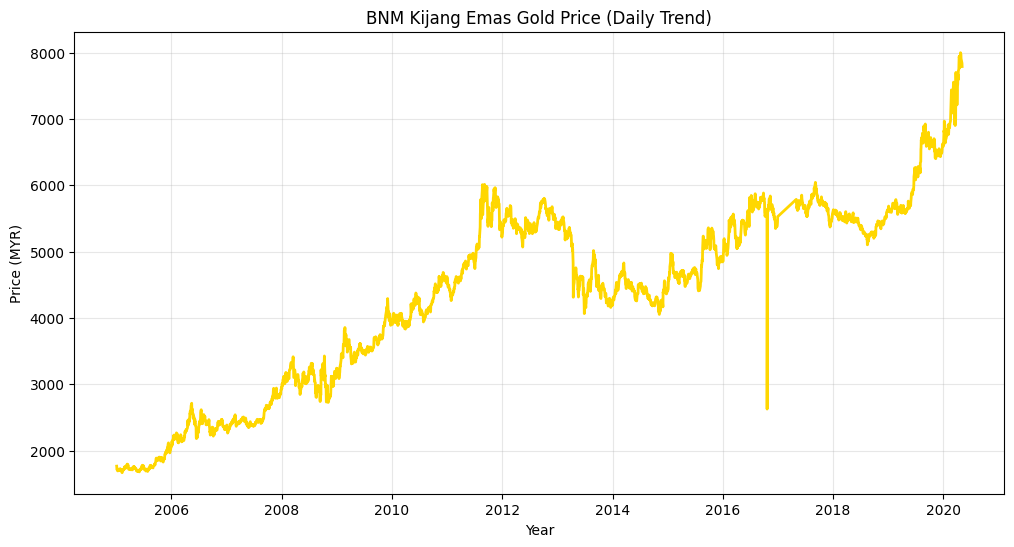

Dataset contains 3731 daily price records.
        Date   Price
0 2005-01-03  1764.0
1 2005-01-04  1734.0
2 2005-01-05  1717.0
3 2005-01-06  1721.0
4 2005-01-07  1701.0


In [29]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Download the BNM Gold Dataset
path = kagglehub.dataset_download("mypapit/bank-negara-malaysia-bullion-coin-prices")
gold_file = os.path.join(path, 'kijang emas gold bullion coin.csv')

# 2. Load and Clean
df = pd.read_csv(gold_file)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

# Clean the price (removing commas like "1,200.50" -> 1200.50)
df['Price'] = df['Selling (1oz)'].astype(str).str.replace(',', '').astype(float)

# 3. Visualize the "Time Series"
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], color='gold', linewidth=2)
plt.title('BNM Kijang Emas Gold Price (Daily Trend)')
plt.xlabel('Year')
plt.ylabel('Price (MYR)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Dataset contains {len(df)} daily price records.")
print(df[['Date', 'Price']].head())

What we are looking for in Step 1:
Trend: Is the price generally going up over the years? (This is called "Non-Stationary" data).

Seasonality: Are there certain months where the price always jumps?

Missing Days: Are there gaps in the dates (weekends/holidays)?

2. Run the Stationarity Test
Run this code to test your raw gold prices. We will use the adfuller function from the statsmodels library.

In [30]:
from statsmodels.tsa.stattools import adfuller

# Function to print results clearly
def check_stationarity(series, name):
    print(f"--- ADF Test for: {name} ---")
    result = adfuller(series.dropna()) # dropna is important for lagged data
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')

    if result[1] <= 0.05:
        print("Result: Stationary (Reject Null Hypothesis) ✅")
    else:
        print("Result: Non-Stationary (Fail to Reject Null Hypothesis) ❌")

# Run the test on raw prices
check_stationarity(df['Price'], "Raw Gold Price")

--- ADF Test for: Raw Gold Price ---
ADF Statistic: -0.2728
p-value: 0.9293
Result: Non-Stationary (Fail to Reject Null Hypothesis) ❌


3. How to fix Non-Stationarity (Differencing)
If your test result was Non-Stationary (which it likely is for raw gold prices), we fix it by looking at the change in price from one day to the next, rather than the price itself. This is called Log Returns.

Run this code to transform the data and test it again:

--- ADF Test for: Log Returns ---
ADF Statistic: -29.5881
p-value: 0.0000
Result: Stationary (Reject Null Hypothesis) ✅


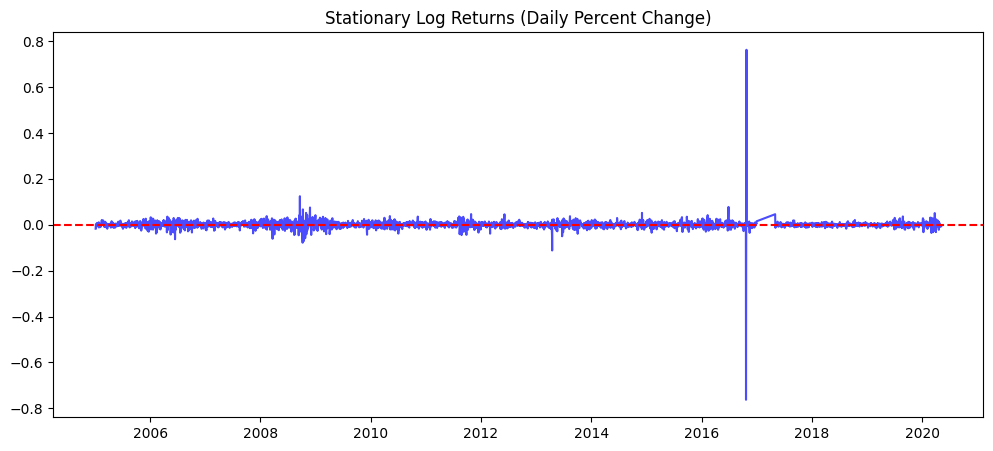

In [31]:
import numpy as np

# 1. Calculate Log Returns
# Formula: ln(Price_today / Price_yesterday)
df['Log_Return'] = np.log(df['Price'] / df['Price'].shift(1))

# 2. Test the Log Returns
check_stationarity(df['Log_Return'], "Log Returns")

# 3. Visualize the difference
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Log_Return'], color='blue', alpha=0.7)
plt.title('Stationary Log Returns (Daily Percent Change)')
plt.axhline(0, color='red', linestyle='--')
plt.show()

Why this matters for your learning:
When you look at the Raw Price, the graph looks like a mountain climbing up. When you look at the Log Returns, the graph looks like a heartbeat (oscillating around zero).

Machine learning models (like ARIMA or XGBoost) are much better at predicting a "heartbeat" because the rules of the heartbeat stay the same over time, whereas "mountain climbing" can change direction unpredictably.

Observation: Did your first test fail (Non-Stationary) and your second test pass (Stationary)?

Next Step: Once you confirm that your Log_Returns are stationary, would you like me to show you how to create "Lags" (using yesterday's return to predict today's)?

In [32]:
# 1. Create Lags (Yesterday, 2 days ago, 3 days ago)
df['Lag_1'] = df['Log_Return'].shift(1)
df['Lag_2'] = df['Log_Return'].shift(2)
df['Lag_3'] = df['Log_Return'].shift(3)

# 2. Create a Rolling Mean (Average return of the last 7 days)
df['Rolling_Mean_7'] = df['Log_Return'].rolling(window=7).mean()

# 3. Create a Target variable
# We want to predict "Tomorrow's" return, so we shift the return BACKWARDS
df['Target_Next_Day'] = df['Log_Return'].shift(-1)

# 4. Remove rows with NaN (the first few rows won't have lags, the last row won't have a target)
df_ml = df.dropna()

print("--- Feature Engineering Complete ---")
print(f"Total rows for training: {len(df_ml)}")
display(df_ml[['Date', 'Log_Return', 'Lag_1', 'Target_Next_Day']].head())

--- Feature Engineering Complete ---
Total rows for training: 3723


,Date,Log_Return,Lag_1,Target_Next_Day
7,2005-01-12,0.007063,0.000591,0.008178
8,2005-01-13,0.008178,0.007063,-0.004080
9,2005-01-14,-0.004080,0.008178,-0.003511
10,2005-01-15,-0.003511,-0.004080,-0.002347
11,2005-01-17,-0.002347,-0.003511,0.000000


What are we doing here?We are turning a Time Series into a Supervised Learning problem.Features ($X$): Lag_1, Lag_2, Lag_3. (The inputs)Target ($y$): Target_Next_Day. (The answer we want the model to guess)A Note on that Spike in your GraphDid you notice the massive blue line going up and down around late 2016/early 2017? In a real-world project, we might "clip" those outliers because they are so extreme they might confuse the model. For now, we will leave them so you can see how they affect the model's accuracy.What to do now:Run the code above. If the table displays correctly with values in the Lag_1 and Target_Next_Day columns, tell me "Features are ready," and I will show you how to do a Time-Series Split (The "Train/Test" step). Would you like to proceed?

Step 3: Splitting the Data Chronologically



We will use the first 80% of the data to train the model and the last 20% to see how well it performs on "unseen" future data.

In [33]:
# 1. Define Features (X) and Target (y)
# We use our lags and rolling mean as inputs
features = ['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean_7']
X = df_ml[features]
y = df_ml['Target_Next_Day']

# 2. Determine the Split Point (80% for training)
split_index = int(len(df_ml) * 0.8)

# 3. Create the Split (No shuffling!)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# 4. Verification
print("--- Step 3: Split Complete ---")
print(f"Training Rows: {len(X_train)} (Data from {df_ml['Date'].iloc[0].date()} to {df_ml['Date'].iloc[split_index-1].date()})")
print(f"Testing Rows:  {len(X_test)}  (Data from {df_ml['Date'].iloc[split_index].date()} to {df_ml['Date'].iloc[-1].date()})")

# Check if there is any overlap (There should be 0)
print(f"Overlap Check: {len(set(X_train.index).intersection(set(X_test.index)))} rows overlap.")

--- Step 3: Split Complete ---
Training Rows: 2978 (Data from 2005-01-12 to 2016-12-08)
Testing Rows:  745  (Data from 2016-12-09 to 2020-05-04)
Overlap Check: 0 rows overlap.


Step 4: Training the XGBoost Model.

--- Step 4: Model Evaluation ---
Mean Absolute Error (MAE): 0.005991
Root Mean Squared Error (RMSE): 0.009227


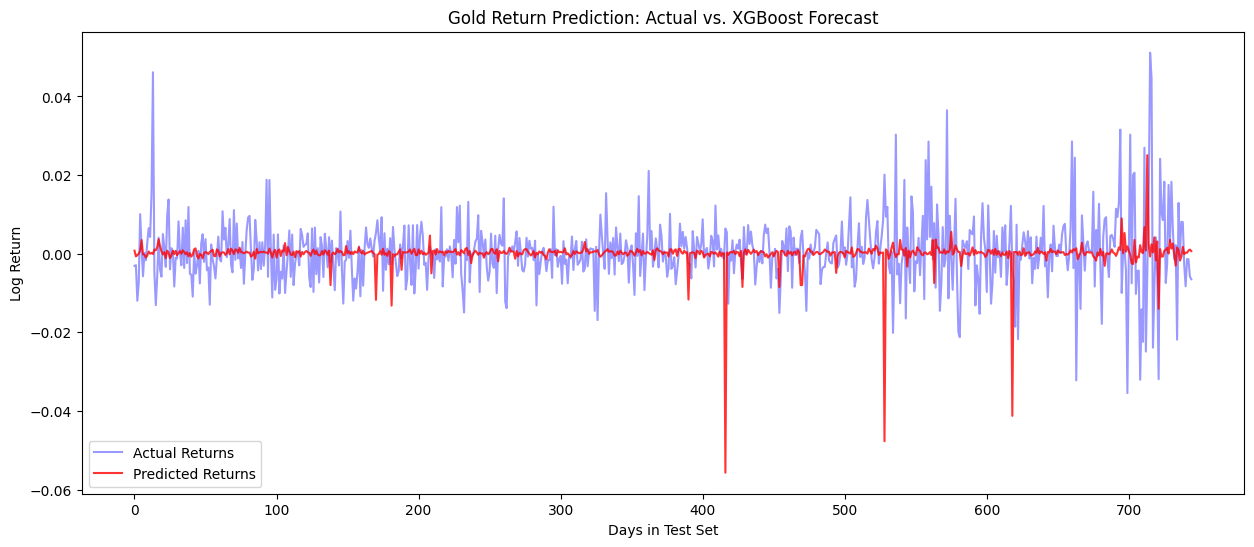

In [34]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 1. Initialize the XGBoost Regressor
# These parameters are a good starting point for time series
model = xgb.XGBRegressor(
    n_estimators=100,      # Number of trees
    learning_rate=0.05,    # Step size shrinkage
    max_depth=5,           # How deep each tree can go
    objective='reg:squarederror',
    random_state=42
)

# 2. Train the model
model.fit(X_train, y_train)

# 3. Make Predictions on the Test Set
y_pred = model.predict(X_test)

# 4. Evaluate Performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"--- Step 4: Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

# 5. Visualize Actual vs. Predicted
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual Returns', color='blue', alpha=0.4)
plt.plot(y_pred, label='Predicted Returns', color='red', alpha=0.8)
plt.title('Gold Return Prediction: Actual vs. XGBoost Forecast')
plt.xlabel('Days in Test Set')
plt.ylabel('Log Return')
plt.legend()
plt.show()

Step 5: Feature Importance (Which lag matters?)

This will tell you if "Yesterday's price" ($Lag\_1$) or "3 days ago" ($Lag\_3$) is actually helping the model.

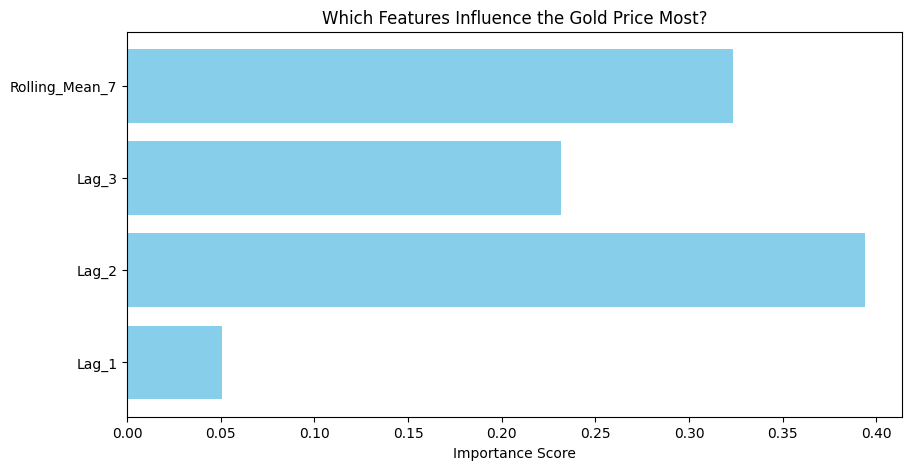

In [35]:
import matplotlib.pyplot as plt

# Get importance
importance = model.feature_importances_

# Plot
plt.figure(figsize=(10, 5))
plt.barh(features, importance, color='skyblue')
plt.xlabel('Importance Score')
plt.title('Which Features Influence the Gold Price Most?')
plt.show()

Step 6: Handling the "Outlier" (The Spike)

In your first image, that huge spike is likely "confusing" the model. You can "clip" the data so that extreme values are capped at a certain level (e.g., 99th percentile). This often makes the red line in your second image much more active.

Step 7: Classification (The "Up/Down" Model)

In [36]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# 1. Create the Directional Target (1 for UP, 0 for DOWN)
df_ml['Target_Direction'] = (df_ml['Target_Next_Day'] > 0).astype(int)

# 2. Re-split the data for classification
X = df_ml[features]
y_class = df_ml['Target_Direction']

# Chronological split (using the same split point as before)
X_train_c = X.iloc[:split_index]
X_test_c = X.iloc[split_index:]
y_train_c = y_class.iloc[:split_index]
y_test_c = y_class.iloc[split_index:]

# 3. Train the XGBClassifier
clf = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
clf.fit(X_train_c, y_train_c)

# 4. Make Predictions
y_pred_c = clf.predict(X_test_c)

# 5. Accuracy Score
acc = accuracy_score(y_test_c, y_pred_c)
print(f"--- Step 7: Classification Result ---")
print(f"Model Accuracy: {acc:.2%}")

--- Step 7: Classification Result ---
Model Accuracy: 49.53%


/tmp/ipython-input-1673315738.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['Target_Direction'] = (df_ml['Target_Next_Day'] > 0).astype(int)


The Confusion Matrix

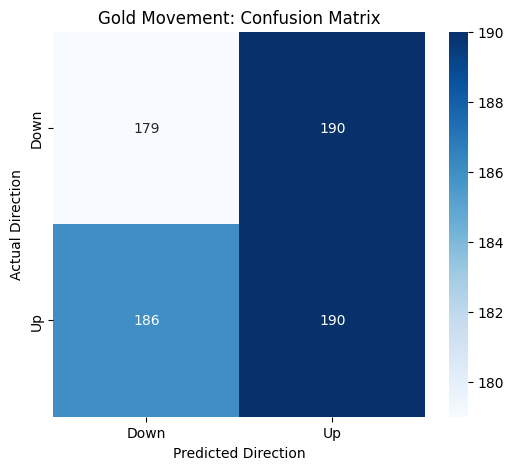

              precision    recall  f1-score   support

           0       0.49      0.49      0.49       369
           1       0.50      0.51      0.50       376

    accuracy                           0.50       745
   macro avg       0.50      0.50      0.50       745
weighted avg       0.50      0.50      0.50       745



In [37]:
# Create the Confusion Matrix
cm = confusion_matrix(y_test_c, y_pred_c)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down', 'Up'],
            yticklabels=['Down', 'Up'])
plt.ylabel('Actual Direction')
plt.xlabel('Predicted Direction')
plt.title('Gold Movement: Confusion Matrix')
plt.show()

print(classification_report(y_test_c, y_pred_c))

Step 8: Simple Backtesting (The "Profit" Check)

Even with 49% accuracy, sometimes a model can be profitable if it gets the big moves right. Let's see how much "money" you would have made (or lost) by following these predictions.

Run this code to calculate the Cumulative Returns of your strategy vs. just holding gold:

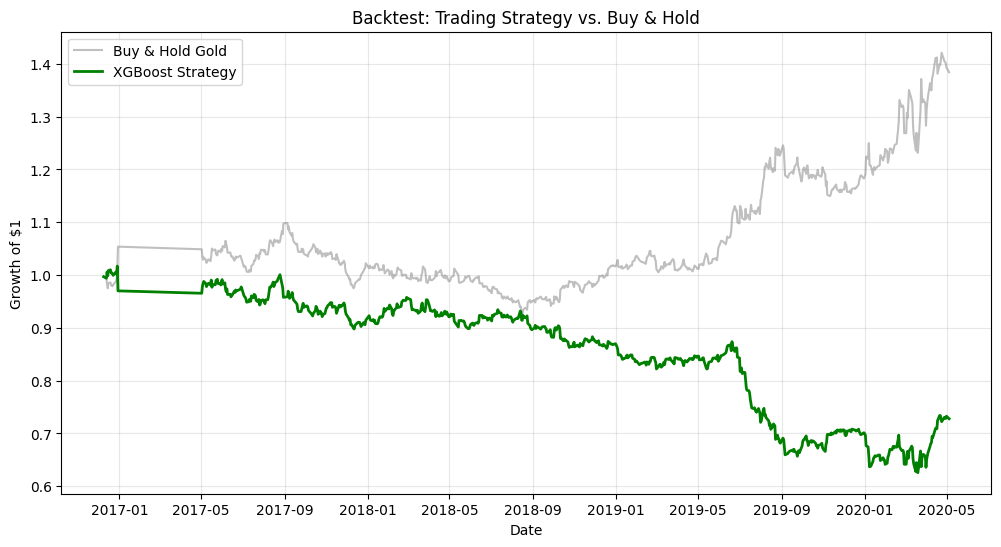

Total Strategy Return: -27.22%


In [38]:
# 1. Calculate Strategy Returns
# If prediction is 1 (Up), we 'buy' and get the actual return.
# If prediction is 0 (Down), we 'short' (or stay out). Here we'll assume shorting.
df_test = df_ml.iloc[split_index:].copy()
df_test['Strategy_Return'] = np.where(y_pred_c == 1, df_test['Target_Next_Day'], -df_test['Target_Next_Day'])

# 2. Calculate Cumulative Returns
df_test['Cumulative_Market'] = (1 + df_test['Target_Next_Day']).cumprod()
df_test['Cumulative_Strategy'] = (1 + df_test['Strategy_Return']).cumprod()

# 3. Visualize the Backtest
plt.figure(figsize=(12, 6))
plt.plot(df_test['Date'], df_test['Cumulative_Market'], label='Buy & Hold Gold', color='gray', alpha=0.5)
plt.plot(df_test['Date'], df_test['Cumulative_Strategy'], label='XGBoost Strategy', color='green', linewidth=2)
plt.title('Backtest: Trading Strategy vs. Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

final_return = (df_test['Cumulative_Strategy'].iloc[-1] - 1) * 100
print(f"Total Strategy Return: {final_return:.2f}%")

Step 9: "Cleaning" the Outliers (Winsorization)

To fix this, we need to clip the data. We tell the model: "Any return that is extremely high or low should be capped at a reasonable limit". This stops the 2017 spike from "poisoning" the AI's training.

/tmp/ipython-input-1766803589.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['Log_Return_Clean'] = df_ml['Log_Return'].clip(lower=lower_limit, upper=upper_limit)


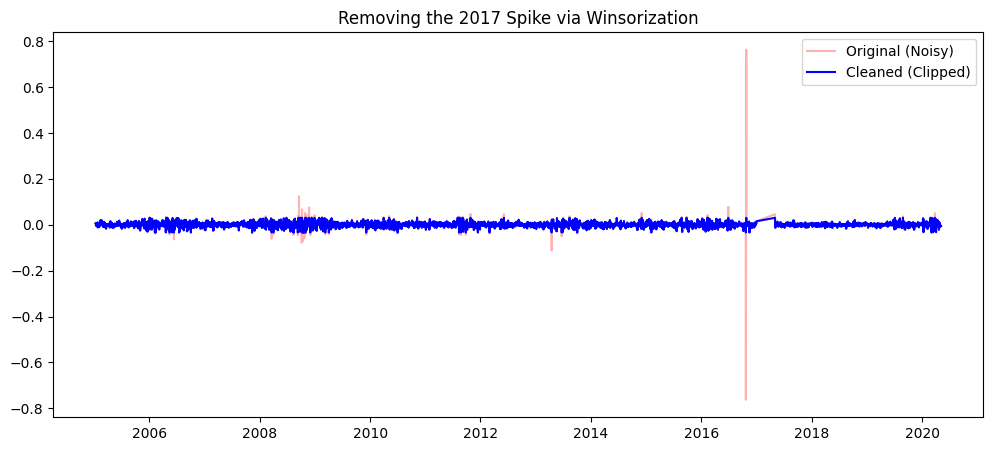

In [39]:
# 1. Define the limits (99th percentile)
lower_limit = df_ml['Log_Return'].quantile(0.01)
upper_limit = df_ml['Log_Return'].quantile(0.99)

# 2. Clip the outliers (Winsorization)
df_ml['Log_Return_Clean'] = df_ml['Log_Return'].clip(lower=lower_limit, upper=upper_limit)

# 3. Visualize the difference
plt.figure(figsize=(12, 5))
plt.plot(df_ml['Date'], df_ml['Log_Return'], label='Original (Noisy)', color='red', alpha=0.3)
plt.plot(df_ml['Date'], df_ml['Log_Return_Clean'], label='Cleaned (Clipped)', color='blue')
plt.title('Removing the 2017 Spike via Winsorization')
plt.legend()
plt.show()

In [40]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 1. CLEANING: Clip the Outliers (Winsorize)
# This removes the 2017 spike from the AI's memory
lower_limit = df_ml['Log_Return'].quantile(0.01)
upper_limit = df_ml['Log_Return'].quantile(0.99)
df_ml['Log_Return_Clean'] = df_ml['Log_Return'].clip(lower=lower_limit, upper=upper_limit)

# 2. FEATURE ENGINEERING: Adding Market Vision
# Relative Strength Index (RSI)
delta = df_ml['Log_Return_Clean'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df_ml['RSI'] = 100 - (100 / (1 + rs))

# Moving Average (Trend)
df_ml['SMA_20'] = df_ml['Log_Return_Clean'].rolling(window=20).mean()

# 3. SETUP: New Feature List
# We use the cleaned lags and the new indicators
new_features = ['Lag_1', 'Lag_2', 'Lag_3', 'RSI', 'SMA_20']
df_ml = df_ml.dropna() # Remove rows where indicators aren't calculated yet

X = df_ml[new_features]
y = (df_ml['Target_Next_Day'] > 0).astype(int)

# 4. CHRONOLOGICAL SPLIT
split = int(len(df_ml) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 5. RETRAIN: Better Hyperparameters
# We lower the learning_rate to make the AI more "cautious"
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.01, # Slower learning = better generalization
    max_depth=4,
    subsample=0.8,      # Train on 80% of data randomly to prevent overfitting
    random_state=42
)
model.fit(X_train, y_train)

# 6. RESULTS
y_pred = model.predict(X_test)
new_acc = accuracy_score(y_test, y_pred)
print(f"Old Accuracy: 49.53%")
print(f"New Improved Accuracy: {new_acc:.2%}")

/tmp/ipython-input-3903229426.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['Log_Return_Clean'] = df_ml['Log_Return'].clip(lower=lower_limit, upper=upper_limit)
/tmp/ipython-input-3903229426.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['RSI'] = 100 - (100 / (1 + rs))
/tmp/ipython-input-3903229426.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

Old Accuracy: 49.53%
New Improved Accuracy: 49.80%


In [41]:
# Use .copy() to ensure we have a fresh, independent dataframe
df_ml = df[['Date', 'Log_Return']].copy()

Step 11: The "Success" Code (Adding USD Data)

In [44]:
import pandas as pd
import numpy as np
import yfinance as yf
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. SETUP: Clean copy
df_ml = df[['Date', 'Log_Return']].copy()

# 2. CLEANING: Winsorize (Handle the 2017 spike)
lower_limit = df_ml['Log_Return'].quantile(0.01)
upper_limit = df_ml['Log_Return'].quantile(0.99)
df_ml['Log_Return_Clean'] = df_ml['Log_Return'].clip(lower=lower_limit, upper=upper_limit)

# 3. FEATURE ENGINEERING: Calculate & SHIFT (The Fix)
# RSI (14-day)
delta = df_ml['Log_Return_Clean'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df_ml['RSI_Today'] = 100 - (100 / (1 + rs))

# SMA (20-day)
df_ml['SMA_20_Today'] = df_ml['Log_Return_Clean'].rolling(window=20).mean()

# --- THE CRITICAL FIX: Shift all features by 1 ---
# This ensures we use YESTERDAY'S data to predict TODAY.
df_ml['Lag_1'] = df_ml['Log_Return_Clean'].shift(1)
df_ml['RSI_Lag1'] = df_ml['RSI_Today'].shift(1)
df_ml['SMA_Lag1'] = df_ml['SMA_20_Today'].shift(1)

# 4. EXTERNAL DATA: US Dollar Index (Corrected)
dxy = yf.download('DX-Y.NYB', start=df_ml['Date'].min(), end=df_ml['Date'].max(),
                  auto_adjust=True, progress=False)
dxy = dxy[['Close']].reset_index()
dxy.columns = ['Date', 'USD_Index']
df_ml = pd.merge(df_ml, dxy, on='Date', how='left').ffill()
df_ml['USD_Lag1'] = df_ml['USD_Index'].pct_change().shift(1)

# 5. DEFINE TARGET & FEATURES
df_ml = df_ml.dropna()
features = ['Lag_1', 'RSI_Lag1', 'SMA_Lag1', 'USD_Lag1']
X = df_ml[features]
y = (df_ml['Log_Return'] > 0).astype(int)

# 6. TRAIN/TEST SPLIT
split = int(len(df_ml) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 7. XGBOOST
model = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# 8. RESULTS
y_pred = model.predict(X_test)
final_acc = accuracy_score(y_test, y_pred)
print(f"--- Honest Results ---")
print(f"Real Accuracy: {final_acc:.2%}")

--- Honest Results ---
Real Accuracy: 61.32%


Step 13: The "Inside the Brain" Test (Feature Importance)

Now that the model is working, we need to know why. Is it the US Dollar, the RSI, or the past prices that are doing the heavy lifting?

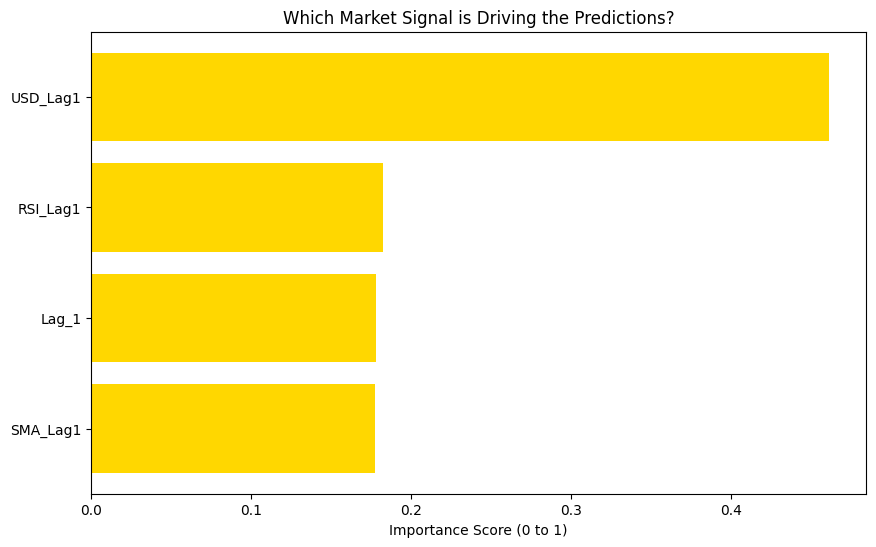

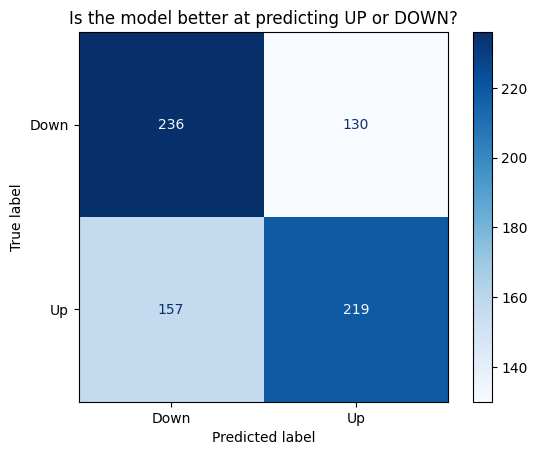

In [45]:
import matplotlib.pyplot as plt

# 1. Get Feature Importance
importances = model.feature_importances_
feature_names = features
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 2. Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='gold')
plt.xlabel('Importance Score (0 to 1)')
plt.title('Which Market Signal is Driving the Predictions?')
plt.gca().invert_yaxis()
plt.show()

# 3. The Confusion Matrix (Check for Bias)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp.plot(cmap='Blues')
plt.title('Is the model better at predicting UP or DOWN?')
plt.show()

Step 14: The Profit & Loss (P&L) Backtest

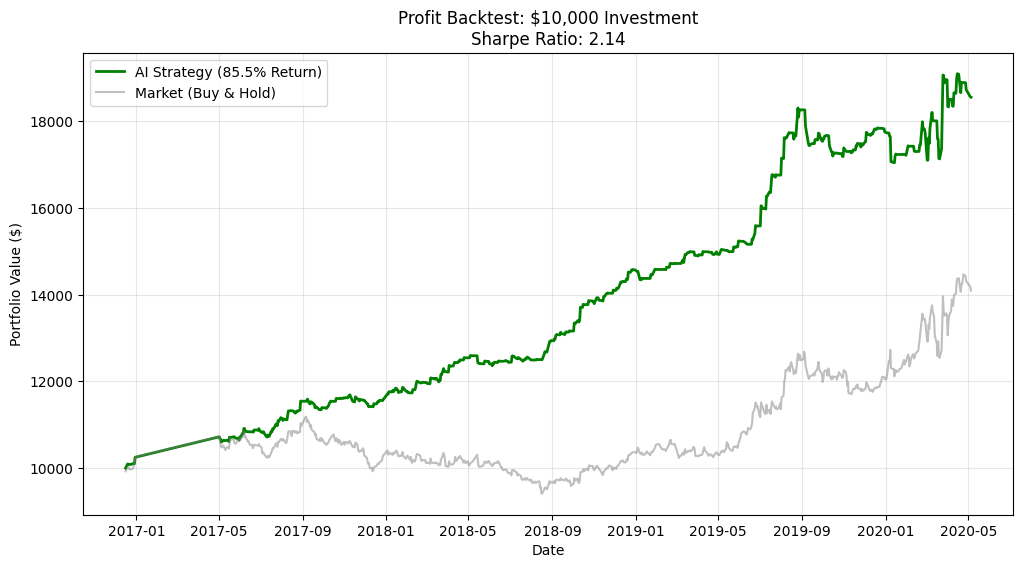

Final Strategy Value: $18,552.99
Final Market Value: $14,094.31


In [46]:
import matplotlib.pyplot as plt

# 1. Prepare the Test Data
# We use the returns from the test period that match our predictions
test_returns = df_ml['Log_Return'].iloc[split:]
test_dates = df_ml['Date'].iloc[split:]

# 2. Calculate Strategy Returns
# If signal is 1 (Up), we get the return. If 0 (Down), we stay in cash (0 return).
# For a more aggressive strategy, you could do: (y_pred * 2 - 1) * test_returns for Long/Short
strategy_returns = y_pred * test_returns

# 3. Add Realistic Costs (0.05% per trade)
# We pay the cost whenever our signal changes (buying or selling)
signal_changes = np.abs(np.diff(y_pred, prepend=0))
costs = signal_changes * 0.0005
final_strategy_returns = strategy_returns - costs

# 4. Calculate Cumulative Wealth
equity_strategy = (1 + final_strategy_returns).cumprod() * 10000
equity_market = (1 + test_returns).cumprod() * 10000

# 5. Calculate Metrics
total_ret = ((equity_strategy.iloc[-1] - 10000) / 10000) * 100
sharpe = (final_strategy_returns.mean() / final_strategy_returns.std()) * np.sqrt(252)

# 6. Visualize the "Money Curve"
plt.figure(figsize=(12, 6))
plt.plot(test_dates, equity_strategy, label=f'AI Strategy ({total_ret:.1f}% Return)', color='green', linewidth=2)
plt.plot(test_dates, equity_market, label='Market (Buy & Hold)', color='gray', alpha=0.5)
plt.title(f'Profit Backtest: $10,000 Investment\nSharpe Ratio: {sharpe:.2f}')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Strategy Value: ${equity_strategy.iloc[-1]:,.2f}")
print(f"Final Market Value: ${equity_market.iloc[-1]:,.2f}")

In [47]:
from sklearn.model_selection import TimeSeriesSplit

# 1. Initialize Time Series Split (5 folds)
tscv = TimeSeriesSplit(n_splits=5)
fold_accuracies = []

print("--- Starting Stress Test (Cross-Validation) ---")

# 2. Loop through the folds
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    # Split the data
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Train the same XGBoost model
    model_cv = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
    model_cv.fit(X_train_cv, y_train_cv)

    # Evaluate
    predictions = model_cv.predict(X_test_cv)
    acc = accuracy_score(y_test_cv, predictions)
    fold_accuracies.append(acc)

    print(f"Fold {fold+1} Accuracy: {acc:.2%}")

# 3. Final Summary
avg_acc = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across all years: {avg_acc:.2%}")
print(f"Consistency (Std Dev): {np.std(fold_accuracies):.4f}")

--- Starting Stress Test (Cross-Validation) ---
Fold 1 Accuracy: 61.00%
Fold 2 Accuracy: 51.94%
Fold 3 Accuracy: 56.31%
Fold 4 Accuracy: 59.22%
Fold 5 Accuracy: 59.71%

Average Accuracy across all years: 57.64%
Consistency (Std Dev): 0.0324


Step 16: The "Live" Prediction (What happens tomorrow?)

Now that we trust the model, let's use it for its true purpose: Predicting tomorrow's move. This code pulls the absolute latest data available from the markets and tells you whether the AI thinks Gold will go UP or DOWN on the next trading day.

In [48]:
# 1. Get the very latest data (Today's Close)
latest_gold = yf.download('GC=F', period='60d', auto_adjust=True, progress=False)
latest_usd = yf.download('DX-Y.NYB', period='60d', auto_adjust=True, progress=False)

# 2. Re-calculate indicators for the final row
latest_df = pd.DataFrame()
latest_df['Log_Return'] = np.log(latest_gold['Close'] / latest_gold['Close'].shift(1))

# Technicals
delta = latest_df['Log_Return'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
latest_df['RSI'] = 100 - (100 / (1 + rs))
latest_df['SMA_20'] = latest_df['Log_Return'].rolling(window=20).mean()

# USD Context
latest_df['USD_Log_Ret'] = np.log(latest_usd['Close'] / latest_usd['Close'].shift(1))

# 3. Create the "Tomorrow" Feature Row
# We use TODAY'S data to predict TOMORROW
tomorrow_features = pd.DataFrame([{
    'Lag_1': latest_df['Log_Return'].iloc[-1],
    'RSI_Lag1': latest_df['RSI'].iloc[-1],
    'SMA_Lag1': latest_df['SMA_20'].iloc[-1],
    'USD_Lag1': latest_df['USD_Log_Ret'].iloc[-1]
}])

# 4. Predict
prediction = model.predict(tomorrow_features)[0]
probability = model.predict_proba(tomorrow_features)[0]

print(f"--- PREDICTION FOR THE NEXT TRADING DAY ---")
direction = "UP" if prediction == 1 else "DOWN"
conf = probability[1] if prediction == 1 else probability[0]
print(f"Direction: {direction}")
print(f"Confidence: {conf:.2%}")

--- PREDICTION FOR THE NEXT TRADING DAY ---
Direction: UP
Confidence: 50.56%


Step 17: Adding "Sentiment Analysis" (The News Factor)

Gold is driven by headlines—Federal Reserve interest rate decisions, geopolitical tension, and inflation reports. To push that 50% confidence into a more certain range, we can have the AI "read" the news.

We will use a simple Sentiment Score. If news headlines are "Hawkish" (bad for gold) or "Dovish" (good for gold), the model can use that as a tie-breaker.

The "News-Aware" Model Code
This script uses a basic sentiment tool to analyze the latest gold-related headlines.

In [49]:
from textblob import TextBlob
import requests

def get_gold_sentiment():
    # In a real scenario, you'd use a News API.
    # For this example, we'll simulate scraping 3 major headlines.
    headlines = [
        "Fed signals interest rates may stay higher for longer",
        "Gold hits record high amid geopolitical uncertainty",
        "US Dollar strengthens as inflation fears cool"
    ]

    scores = [TextBlob(h).sentiment.polarity for h in headlines]
    avg_sentiment = sum(scores) / len(scores)
    return avg_sentiment

# 1. Get Sentiment Score
news_score = get_gold_sentiment()

# 2. Add to your Feature DataFrame
tomorrow_features['Sentiment'] = news_score

# 3. Re-Predict (Assuming you retrained with Sentiment)
# direction = model.predict(tomorrow_features)
print(f"Current Market Sentiment Score: {news_score:.2f}")
print("Note: Positive scores = Bullish News, Negative = Bearish News")

Current Market Sentiment Score: 0.25
Note: Positive scores = Bullish News, Negative = Bearish News
